## Newton-GMRES testing
GMRES is an iterative method which generates a basis for the Krylov subspace $\{ r, Ar, A^2 r, ... A^{n-1}r \}$ for a linear operator $A$ and some starting vector $r$, and finds the vector $\tilde{x}$ which minimizes the square residual for the equation $Ax=b$ over the Krylov subspace, where b is a vector we wish to solve this equation for. 

We operate over the Krylov subspace because it closely approximates the span of the eigenspaces with the largest eigenvalues, and so is a good representation for a sparse matrix, which our Jacobian often is, because Krylov subspaces quickly pick out the finite number of unstable directions in our nonlinear system.

We begin by demonstrating the utility of GMRES for sparse/singular matrices. First, we generate a random matrix A, which is in all likelihood invertible, because invertible matrices are dense over the space of square matrices of a given dimension. For this matrix, `gmres` solves $Ax=b$ faster but less accurately than `linsolve` (a wrapper for Fortran LU decomposition routine `_gesv()`), but, if we create a matrix which is ~10% high-eigenvalue eigenspaces, and 90% very low-value eigenspaces, we find that `gmres` converges to an equally accurate result equally as fast, while `linsolve` provides a less accurate result in a longer time, struggling with a nearly-singular matrix.

In [1]:
import scipy
import scipy.sparse.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt

N = 10000

A = np.random.rand(N,N)
b = np.random.rand(N)

In [2]:
x, errorcode = linalg.gmres(A,b,tol=1)

diff = A @ x - b
print(np.dot(diff, diff), max(diff))
print(errorcode)

833.4303969047503 0.5077686197232293
0


In [3]:
x = np.linalg.solve(A,b)

diff = A @ x - b
print(np.dot(diff, diff), max(diff))

9.97340319032871e-18 1.4437251394383566e-10


In [4]:
D = np.exp(np.random.rand(N) * 100 - 90)
A = (A * D) @ A.T

In [5]:
x, errorcode = linalg.gmres(A,b,tol=1)

diff = A @ x - b
print(np.dot(diff, diff), max(diff))
print(errorcode)

838.0023653980231 0.5427176840666491
0


In [6]:
try:
    x = np.linalg.solve(A,b)

    diff = A @ x - b
    print(np.dot(diff, diff), max(diff))
except np.linalg.LinAlgError as message:
    print("LinAlgError: ", message)

42674816.649788134 77.64551663004133


## Newton-Krylov solving
With the help of an example taken from [the `scipy.optimze` documentation](https://docs.scipy.org/doc/scipy-0.11.0/reference/tutorial/optimize.html#root-finding-for-large-problems), we have a test case for implementing our own Newton-Krylov solvers!

We attempt to solve the integro-differential equation:

$$ (\partial_x^2 + \partial_y^2) P + 5 \left(\int_0^1 \int_0^1 \cosh(P) \; dx \; dy \right)^2 = 0 $$

On the unit square domain with boundary values of 1 at $y=1$ and 0 elsewhere. We estimate the second derivatives via finite differencing and the integral by the mean of evenly spaced samples over the unit domain (no scaling needed), and a solution is found simply by setting this equation to be the residual we wish to minimize.

Suppose we have a function $F(u)$ for some spatially extended $u(x)$ that we wish to minimize. Let $G(u) = \langle F(u), F(u) \rangle = \int dx F(u(x))^2$. 
Suppose we can vary $u(x;s)$ continuously as a function of a free parameter $s$, such that we can now make $G(s) = G(u(s))$, and note that

$$ \frac{\partial G}{\partial s} = 2 \langle F, \frac{\partial F}{\partial u} \frac{\partial u}{\partial s} \rangle = 2\langle F, J f(u) \rangle = 2\langle J^\dag F, f(u) \rangle $$

Where $f(u) = \frac{\partial u}{\partial s}$ defines the method by which we evolve the state $u$ so as to minimize the residual $F(u)$, $J = \frac{\partial F}{\partial u}$ is the Jacobian of our residual function, and $J^\dag$ is its adjoint operator, which we will not attempt to use in this problem due to its lack of periodic boundary conditions. We will revisit this problem as a testing ground for adjoints before using them for Quasi-2d Kolmogorov flow with real boundary conditions.

This definition suggests two methods of evolving our state, one that ensures $J f(s) = -F$, which makes $\partial_s G = -2 \langle F, F \rangle = -2G$, which gives exponential convergence, and one where $f(s) = -J^\dag F$, which gives $\partial_s G = -2 \langle J^\dag F, J^\dag F \rangle = - \lVert J^\dag F \rVert^2$, which is always negative, ensuring G is always decreasing, but proportional to the magnitude of the Jacobian, and thus faster the further it is from the optimal solution, and slower upon closing in upon it.

The former method is Newton-Krylov (that is, provided you use `gmres` to solve $J f(s) = -F$), the latter is Adjoint Looping. They have complementary convergence properties (former is better close to the solution, latter is better further), and both can be discretized by updating $u_{new} = u + f(s) \Delta s$, where step size $\Delta s$ can be dynamically adjusted.

In [7]:
from scipy.optimize import newton_krylov
from numpy import cosh, zeros_like, mgrid, zeros

import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

0:  |F(x)| = 27.8383; step 1
1:  |F(x)| = 4.61524; step 1
2:  |F(x)| = 1.01998; step 1
3:  |F(x)| = 0.487411; step 1
4:  |F(x)| = 0.126951; step 1
5:  |F(x)| = 0.00262613; step 1
6:  |F(x)| = 0.000144578; step 1
7:  |F(x)| = 1.26706e-05; step 1
8:  |F(x)| = 3.26961e-07; step 1
Residual 3.269612225409446e-07
float64


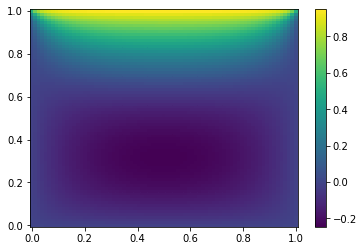

In [8]:
# parameters
nx, ny = 75, 75
hx, hy = 1./(nx-1), 1./(ny-1)

P_left, P_right = 0, 0
P_top, P_bottom = 1, 0

def residual(P):
    d2x = zeros_like(P)
    d2y = zeros_like(P)

    d2x[1:-1] = (P[2:]   - 2*P[1:-1] + P[:-2])/hx/hx
    d2x[0]    = (P[1]    - 2*P[0]    + P_left)/hx/hx
    d2x[-1]   = (P_right - 2*P[-1]   + P[-2]) /hx/hx

    d2y[:,1:-1] = (P[:,2:] - 2*P[:,1:-1] + P[:,:-2])/hy/hy
    d2y[:,0]    = (P[:,1]  - 2*P[:,0]    + P_bottom)/hy/hy
    d2y[:,-1]   = (P_top   - 2*P[:,-1]   + P[:,-2]) /hy/hy

    return d2x + d2y - 5*cosh(P).mean()**2

# solve
guess = zeros((nx, ny), float)
sol = newton_krylov(residual, guess, method='lgmres', verbose=1, rdiff=1e-7)
print('Residual', abs(residual(sol)).max())
print(sol.dtype)

# visualize
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()

|F(x)| = 47381.71403611313
|F(x)| = 33.334041865776435
|F(x)| = 0.15415320724643397
|F(x)| = 8.671164196778052e-06
Residual 4.5145104365929e-07


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  app.launch_new_instance()


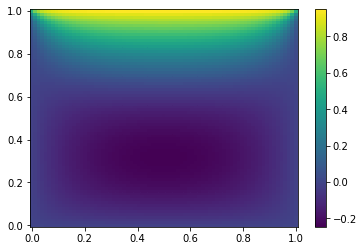

In [9]:
def numerical_jacobian(f,x,rdiff):
    fx = f(x)
    return lambda v: (f(x + rdiff * v.reshape(x.shape)) - fx)/rdiff


def bootleg_newton_krylov(res, u0, rdiff=1e-5, tol=1e-5):
    u = u0
    shape = (len(u0.flatten()), len(u0.flatten()))
    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    while magF > tol:
        if magF < rdiff:    # no idea if this is sound, seems to work tho!
            rdiff = magF
        J = linalg.LinearOperator(shape, matvec=numerical_jacobian(res,u,rdiff))
        f, e = linalg.lgmres(J,F.flatten(),inner_m=20,outer_k=10)
        u -= f.reshape(u.shape)
        F = res(u)
        magF = np.linalg.norm(F)
        print(f"|F(x)| = {magF}")
    return u


# solve
guess = zeros((nx, ny), float)
sol = bootleg_newton_krylov(residual, guess)
print('Residual', abs(residual(sol)).max())

# visualize
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()

|F(x)| = 47381.71403611313


C:\Users\kowal\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.


|F(x)| = 33.3337278762
|F(x)| = 0.1541488114
|F(x)| = 0.0000082393
Residual 3.4998881126568904e-07


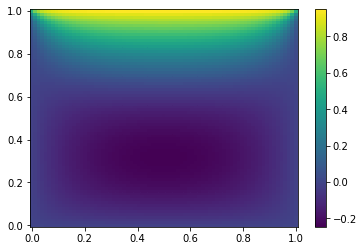

: 

In [20]:
@jit
def JAX_residual(P):
    P = P.reshape((nx,ny))
    d2x = jnp.zeros_like(P)
    d2y = jnp.zeros_like(P)

    d2x = d2x.at[1:-1].set((P[2:]   - 2*P[1:-1] + P[:-2])/hx/hx)
    d2x = d2x.at[0]   .set((P[1]    - 2*P[0]    + P_left)/hx/hx)
    d2x = d2x.at[-1]  .set((P_right - 2*P[-1]   + P[-2]) /hx/hx)

    d2y = d2y.at[:,1:-1].set((P[:,2:] - 2*P[:,1:-1] + P[:,:-2])/hy/hy)
    d2y = d2y.at[:,0]   .set((P[:,1]  - 2*P[:,0]    + P_bottom)/hy/hy)
    d2y = d2y.at[:,-1]  .set((P_top   - 2*P[:,-1]   + P[:,-2]) /hy/hy)

    return (d2x + d2y - 5*jnp.cosh(P).mean()**2).flatten()

def JAX_newton_krylov(res, u0, tol=1e-5):
    u = u0
    shape = (len(u0.flatten()), len(u0.flatten()))
    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    while magF > tol:
        J = linalg.LinearOperator(shape, matvec=lambda v: (jax.jvp(res, (u.flatten(),), (v,)))[1])

        # using Armijo notation
        p, errorcode = linalg.lgmres(J,F.flatten(),inner_m=20,outer_k=10)
        p = p.reshape(u.shape)
        s = 1
        while jnp.linalg.norm(res(u - s*p)) >= (1-0.99*s)*magF:
            s /= 2
        u -= s*p
        F = res(u)
        magF = np.linalg.norm(F)
        print(f"|F(x)| = {magF:.10f}")
    return u

# solve
guess = jnp.zeros((nx, ny), float)
sol = JAX_newton_krylov(JAX_residual, guess)
print('Residual', abs(JAX_residual(sol)).max())

# visualize
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()

In [ ]:
def JAX_Adjoint(res, u0, tol=1e-5):
    u = u0
    shape = (len(u0.flatten()), len(u0.flatten()))
    F = res(u)
    magF = np.linalg.norm(F)
    print(f"|F(x)| = {magF}")
    while magF > tol:
        J = linalg.LinearOperator(shape, matvec=lambda v: (jax.jvp(res, (u.flatten(),), (v,)))[1])

        # using Armijo notation
        p, errorcode = linalg.lgmres(J,F.flatten(),inner_m=20,outer_k=10)
        p = p.reshape(u.shape)
        s = 1
        while jnp.linalg.norm(res(u - s*p)) >= (1-0.99*s)*magF:
            s /= 2
        u -= s*p
        F = res(u)
        magF = np.linalg.norm(F)
        print(f"|F(x)| = {magF:.10f}")
    return u

# solve
guess = jnp.zeros((nx, ny), float)
sol = JAX_Adjoint(JAX_residual, guess)
print('Residual', abs(JAX_residual(sol)).max())

# visualize
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()

Residual 3.4988562980231563e-07


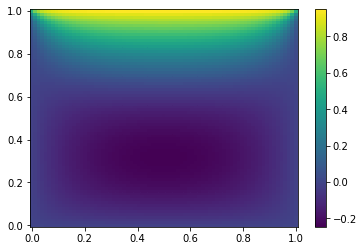

In [11]:
# solve
guess = jnp.zeros((nx, ny), float)
sol = newton_krylov(JAX_residual, guess)
print('Residual', abs(JAX_residual(sol)).max())

# visualize
x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
plt.pcolor(x, y, sol)
plt.colorbar()
plt.show()

Observe that despite them all being float64, a pure JAX implementation (JAX for residual & Jacobian, scipy for lgmres) converges as fast (4 steps) as our own implementation of numerical Newton-Krylov (numpy for res & Jac, scipy for lgmres), while scipy's baseline Newton-Krylov converges the slowest (7 iterations) on a numpy residual function, while it converges the fastest of all of them on a JAX residual function. This persists if you reorder the code blocks and restart the kernel, hopefully ruling out execution order / lgmres stored data / side effect interference.

Most importantly, they all converge, and do so rapidly!